### VAE

На данном семинаре мы попробуем обучить VAE (variational autoencoder) на данных MNIST

#### Подготовим всё необходимое

Импортируем необходимые библиотеки

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from ipywidgets import interact
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab as pl
from IPython import display
import numpy as np
from functools import reduce

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

Задаём параметры обучения и гиперпараметры будущей модели

In [3]:
# Device configuration
device = torch.device('cpu')

# Hyper-parameters
im_size = 28
z_dim = 20
num_epochs = 15
batch_size = 32
learning_rate = 1e-3

Загружаем и визуализируем данные:

In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [ ]:
@interact(i=(0, len(dataset)-1))
def f(i):
    print(dataset[i][1])
    plt.imshow(dataset[i][0].numpy()[0], cmap='gray')

interactive(children=(IntSlider(value=29999, description='i', max=59999), Output()), _dom_classes=('widget-int…

In [5]:
cnt = Counter([d[1] for d in dataset])
s = sum(cnt.values())
for k in sorted(cnt.keys()):
    print('%d: %d/%d (%.3f%%)' % (k, cnt[k], s, 100 * cnt[k] / s))

0: 5923/60000 (9.872%)
1: 6742/60000 (11.237%)
2: 5958/60000 (9.930%)
3: 6131/60000 (10.218%)
4: 5842/60000 (9.737%)
5: 5421/60000 (9.035%)
6: 5918/60000 (9.863%)
7: 6265/60000 (10.442%)
8: 5851/60000 (9.752%)
9: 5949/60000 (9.915%)


#### Создадим модель VAE, основанную на полносвязных слоях (вытягиваем картинку в вектор)

In [6]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=im_size*im_size, z_size=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, 400)
        self.fc2 = nn.Linear(400, 128)
        self.fc3 = nn.Linear(128, z_size)
        self.fc4 = nn.Linear(128, z_size)
        self.fc5 = nn.Linear(z_size, 400)
        self.fc6 = nn.Linear(400, image_size)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x), self.fc4(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc5(z))
        return F.sigmoid(self.fc6(x))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [7]:
def train(model, data_reader, optimizer, inp_shape, num_epochs=num_epochs):
    loss1 = []
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(inp_shape)
            x_reconst, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Visualization:
            if (i+1) % 100 == 0:
                loss1.append(loss.item())
                pl.plot(loss1, color='red')
                display.clear_output(wait=True)
                display.display(pl.gcf())
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                      .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

In [ ]:
z_size = 20
model = VAE(z_size=z_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, data_loader, optimizer, (-1, im_size * im_size))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
import numpy as np
orig_idx = [np.where(dataset.targets == y)[0][0] for y in range(10)]
X_orig = torch.cat([dataset[i][0] for i in orig_idx], dim=0).view(-1, 1, im_size, im_size)

In [0]:
import matplotlib.pyplot as plt
def imconcat(images, dim):
  return torch.cat([im for im in images], dim=dim).cpu()

Random sampling from manifold


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


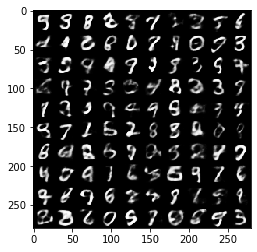

Random sampling from latent code distribution


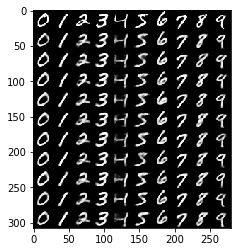

In [0]:
print('Random sampling from manifold')
with torch.no_grad():
    # Save the sampled images
    z = torch.randn(10*10, z_size).to(device)
    out = model.decode(z).view(10, 10, im_size, im_size)
    im = imconcat(imconcat(out, dim=1), dim=1)
    plt.imshow(im.cpu(), cmap='gray')
    plt.show()

print('Random sampling from latent code distribution')
im = imconcat(X_orig.view(-1, im_size, im_size), dim=1)
with torch.no_grad():
  mu, log_var = model.encode(X_orig.view(-1, im_size * im_size).cuda())
  for i in range(10):
    z = model.reparameterize(mu, log_var)# + np.log(10))
    out = model.decode(z)
    im = imconcat([im, imconcat(out.cpu().view(-1, im_size, im_size), dim=1)], dim=0)

plt.imshow(im, cmap='gray')
plt.show()

#### Создадим модель VAE, основанную на свёрточных слоях

In [0]:
class VAE_conv(nn.Module):
    def __init__(self, z_size):
        super(VAE_conv, self).__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            nn.ReLU(True),
        )

        x = torch.zeros((1, 1, im_size, im_size))
        self._to_linear = reduce(lambda x, y: x*y, (self.conv_encoder(x).shape))
        self.fc1 = nn.Linear(self._to_linear, z_size)
        self.fc2 = nn.Linear(self._to_linear, z_size)
        self.fc3 = nn.Linear(z_size, self._to_linear)

        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            #nn.Tanh()
        )

    def encode(self, x):
      x = self.conv_encoder(x)
      mu = self.fc1(x.view(-1, self._to_linear))
      std = self.fc2(x.view(-1, self._to_linear))
      return mu, std

    def decode(self, x):
      x = self.fc3(x)
      x = self.conv_decoder(x.view(-1, 8, 2, 2))
      return F.sigmoid(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, std = self.encode(x)
        z = self.reparameterize(mu, std)
        x = self.decode(z)
        return x, mu, std

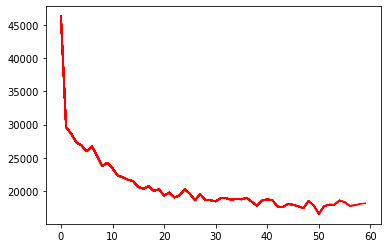

Epoch[15/15], Step [400/469], Reconst Loss: 16100.9990, KL Div: 2031.0964


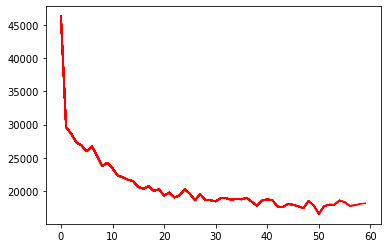

In [0]:
z_size = 20
model = VAE_conv(z_size=z_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, data_loader, optimizer, (-1, 1, im_size, im_size))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


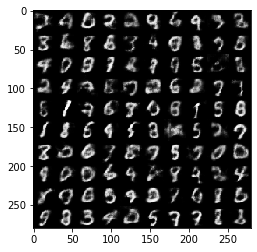

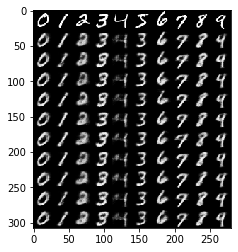

In [0]:
with torch.no_grad():
    # Save the sampled images
    z = torch.randn(10*10, z_size).to(device)
    out = model.decode(z).view(10, 10, im_size, im_size)
    im = imconcat(imconcat(out, dim=1), dim=1)
    plt.imshow(im.cpu(), cmap='gray')
    plt.show()

im = imconcat(X_orig.view(-1, im_size, im_size), dim=1)
with torch.no_grad():
  mu, log_var = model.encode(X_orig.view(-1, 1, im_size, im_size).cuda())
  for i in range(10):
    z = model.reparameterize(mu, log_var)
    out = model.decode(z)
    im = imconcat([im, imconcat(out.cpu().view(-1, im_size, im_size), dim=1)], dim=0)

plt.imshow(im, cmap='gray')
plt.show()

Попробуем теперь обучить модель с размером латентного кода равным 2, и попробуем визуализировать полученные данные.

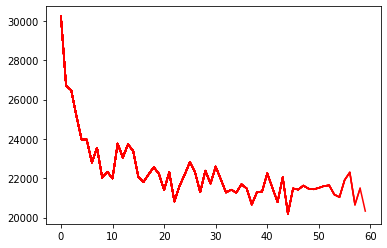

Epoch[15/15], Step [400/469], Reconst Loss: 19671.6582, KL Div: 659.0850


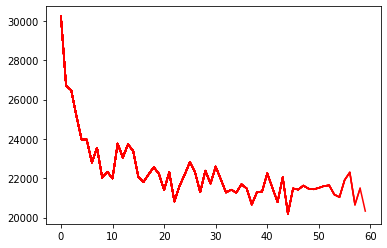

In [0]:
z_size = 2
model = VAE_conv(z_size=z_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, data_loader, optimizer, (-1, 1, im_size, im_size))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


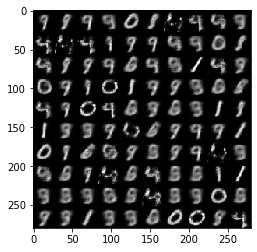

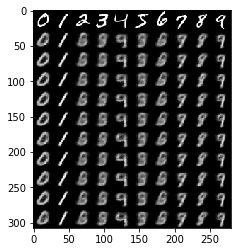

In [0]:
with torch.no_grad():
    # Save the sampled images
    z = torch.randn(10*10, z_size).to(device)
    out = model.decode(z).view(10, 10, im_size, im_size)
    im = imconcat(imconcat(out, dim=1), dim=1)
    plt.imshow(im.cpu(), cmap='gray')
    plt.show()

im = imconcat(X_orig.view(-1, im_size, im_size), dim=1)
with torch.no_grad():
  mu, log_var = model.encode(X_orig.view(-1, 1, im_size, im_size).cuda())
  for i in range(10):
    z = model.reparameterize(mu, log_var)
    out = model.decode(z)
    im = imconcat([im, imconcat(out.cpu().view(-1, im_size, im_size), dim=1)], dim=0)

plt.imshow(im, cmap='gray')
plt.show()

Видим, что изображения получаются нечёткие, а так же, модель путает значения цифр (например, генерирует 9, получая на вход 7). Это вызвано тем, что, по всей видимости, размерности латентного кода маля для кодирования изображений из обучающей выборки.

Попробуем визуализировать получившиеся коды:

In [0]:
z = []
y = []
for data, labels in data_loader:
  z.extend(model.encode(data.to(device))[0].tolist())
  y.extend(list(map(int, labels)))
z = np.array(z)
y = np.array(y)

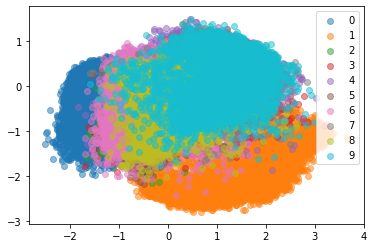

In [0]:
for i in range(10):
  plt.scatter(x=z[y == i, 0], y=z[y == i, 1], label=i, alpha=0.5)
plt.legend()
plt.show()

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne = TSNE()
X = dataset.data.numpy().reshape(-1, im_size * im_size)[:1000]
y = np.array(dataset.targets)[:1000]
X = tsne.fit_transform(X[:1000])

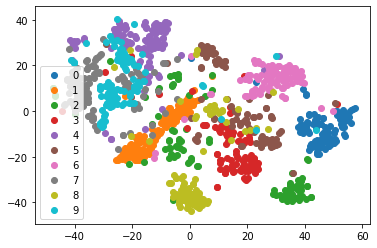

In [0]:
for i in range(10):
  plt.scatter(x=X[y == i, 0], y=X[y == i, 1], label=i)
plt.legend()
plt.show()

#### Conditional Variational Autoencoder

Теперь построим CVAE модель. Её отличие в том, что на вход энкодеру и декодеру подаётся значение цифры. Таким образом, модели уже не нужно запоминать значение цифры в латентном коде, т.к. одно добавляется нами вручную.

**Упражнение:** Реализуйте CVAE, модифицировав VAE с использованием полносвязных слоёв, который был разобран в начале семинара. 

Значения лэйблов (y) в виде one-hot векторов нужно присоединить (конкатенировать) к векторам, которые подаются на вход энкодеру и декодеру.

Для получение one-hot векторов используйте функцию F.one_hot(input, n_classes)

In [0]:
# CVAE model
class CVAE(nn.Module):
    def __init__(self, image_size=im_size*im_size, z_size=20):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear("YOUR CODE GOES HERE", 400)
        self.fc2 = nn.Linear(400, 128)
        self.fc3 = nn.Linear(128, z_size)
        self.fc4 = nn.Linear(128, z_size)
        self.fc5 = nn.Linear("YOUR CODE GOES HERE", 400)
        self.fc6 = nn.Linear(400, image_size)
        
    def encode(self, x, y):
        x = # YOUR CODE GOES HERE
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x), self.fc4(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = # YOUR CODE GOES HERE
        x = F.relu(self.fc5(z))
        return F.sigmoid(self.fc6(x))
    
    def forward(self, x, y1, y2):
        mu, log_var = # YOUR CODE GOES HERE
        z = self.reparameterize(mu, log_var)
        x_reconst = # YOUR CODE GOES HERE
        return x_reconst, mu, log_var

SyntaxError: ignored

In [0]:
def train(model, data_reader, optimizer, inp_shape, num_epochs=num_epochs):
  # Start training
  loss1 = []
  for epoch in range(num_epochs):
    for i, (x, y) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(inp_shape)
        y = # YOUR CODE GOES HERE
        x_reconst, mu, log_var = # YOUR CODE GOES HERE

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            loss1.append(loss.item())
            pl.plot(loss1, color='red')
            display.clear_output(wait=True)
            display.display(pl.gcf())
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                  .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

In [0]:
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, data_loader, optimizer, (-1, im_size * im_size), num_epochs)

Попробуем посэмплировать изображения, варьируя латентный код. Заметим, что теперь цифра, получающаяся при сэмплировании действительно не зависит от латентного кода. Теперь латентный код задаёт только "стиль" написания цифры.

In [0]:
n = 10
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры, берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, lbl, show=True):
    with torch.no_grad():
      # Рисование цифр из многообразия
      figure = np.zeros((im_size * n, im_size * n))
      input_lbl = np.zeros((1, 10))
      input_lbl[0, lbl] = 1
      for i, yi in enumerate(grid_y):
          for j, xi in enumerate(grid_x):
              z_sample = np.zeros((1, 20))
              z_sample[:, :2] = np.array([[xi, yi]])
              z_sample = torch.tensor(z_sample, dtype=torch.float).to(device)
              input_lbl = torch.tensor(input_lbl, dtype=torch.float).to(device)
              x_decoded = model.decode(z_sample, input_lbl).cpu().numpy().reshape((im_size, im_size))
              digit = x_decoded.squeeze() 
              figure[i * im_size: (i + 1) * im_size,
                    j * im_size: (j + 1) * im_size] = digit
      if show:
          # Визуализация
          plt.figure(figsize=(10, 10))
          plt.imshow(figure, cmap='gray')
          plt.grid(False)
          ax = plt.gca()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          plt.show()
      return figure

In [0]:
for i in range(10):
  draw_manifold(model, i)

#### Sources

sources:

> https://arxiv.org/pdf/1312.6114.pdf

> https://habr.com/ru/post/331552/

> https://habr.com/ru/post/331664/

> https://github.com/yunjey/pytorch-tutorial

> https://github.com/L1aoXingyu/pytorch-beginner